# Capacitated Vehicle Routing Problem with Drones



# Outline
- [&nbsp;&nbsp;1.1 Goals](#toc_40015_1.1)
- [&nbsp;&nbsp;1.2 Useful References](#toc_40015_1.2)
- [2 Notation <a name='Notation'></a>](#toc_40015_2)
- [3 Optimization model](#toc_40015_3)
- [&nbsp;&nbsp;3.1 Assumptions](#toc_40015_3.1)
- [&nbsp;&nbsp;3.2 Input Parameters](#toc_40015_3.2)
- [&nbsp;&nbsp;3.3 Full model](#toc_40015_3.3)
- [&nbsp;&nbsp;3.4 Illustration of Results](#toc_40015_3.4)
- [4 Experiments](#toc_40015_4),
- [&nbsp;&nbsp;4.1 ](#toc_40015_4.1)
- [&nbsp;&nbsp;4.2 ](#toc_40015_4.2)


<a name="toc_40015_1.1"></a>
## 1.1 Goals

The capacitated VRPD model presented in this notebook is based on the classical VRP.
In order to service all customers and ensure that the entire demand is not more than each truck's capacity, the goal is to allocate a sequence of clients (a route) to each vehicle either by truck or drone while limiting the overall distance traveled.

<a name="toc_40015_1.2"></a>
## 1.2 Useful References
- **Developing a Vans-and-Drones System for Last-Mile Delivery** by Kristina Charlotte Pedersen Aasen(Master’s Thesis) [munin.uit.no](https://munin.uit.no/bitstream/handle/10037/23277/thesis.pdf?sequence=2)

<a name="toc_40015_2"></a>
# 2 Notation <a name='Notation'></a>
Here is a summary of some of the notation you will encounter:  



|General <img width=70/> <br />  Notation  <img width=70/> | Description<img width=350/>| Value |
|: ------------|: ------------------------------------------------------------||
| customers | Number of customers                                   ||
| n_node | Number of all nodes                                                      ||
| k | Number of trucks                                      ||
| l |  Number of drones   ||
| QR |  Capacity of  truck k   |20 Kg|
| QD |  Capacity of drone  l    |2 Kg|
| $dis1_{i,j}$ |  Manhattan Distance  ||
| $dis2_{i,j}$ |  Euclidean Distance   ||
| **Decision variables** |         |    |     |
|  $\mathbf{x_{i,j,k}}$ | Training   | (0,1) |   |
|  $\mathbf{y_{i,j,l}}$  | Training   | (0,1) 


In [259]:
!pip install pulp

Defaulting to user installation because normal site-packages is not writeable


In [260]:
import itertools

import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
import pulp

import warnings
warnings.filterwarnings("ignore")

In [261]:
customers = 6
n_node = customers + 1

# the number of truck
trucks = 1
# the number of drone
drones = 2

truck_capacity = 20
drone_capacity = 7


np.random.seed(0)

depot_long = 62.438
depot_lat = 9.427

df = pd.DataFrame({"long":np.random.logistic(depot_long, 1.32, n_node ),
                  "lat":np.random.logistic(depot_lat, 2.24, n_node ),
                  "demand":np.random.randint(1, 10, n_node )})


df.iloc[0,0] = depot_long
df.iloc[0,1] = depot_lat
df.iloc[0,2] = 0

print(df)

        long        lat  demand
0  62.438000   9.427000       0
1  63.653354  16.769492       5
2  62.988430   8.363076       4
3  62.675623  12.418195       1
4  62.031720   9.686187       4
5  63.231372  10.040485       6
6  62.106733  15.073900       1


In [262]:
print(df[['lat', 'long']])

         lat       long
0   9.427000  62.438000
1  16.769492  63.653354
2   8.363076  62.988430
3  12.418195  62.675623
4   9.686187  62.031720
5  10.040485  63.231372
6  15.073900  62.106733


In [263]:
print(df.long[1])

63.65335414838415


In [264]:
# get distance matrix
from scipy.spatial import distance_matrix
#p = 1, Manhattan Distance

distance_truck = pd.DataFrame(distance_matrix(df[['long', 'lat']].values, df[['long', 'lat']].values, p=1), index=df.index, columns=df.index).values
dis1 = distance_truck
print(dis1)

[[0.         8.55784635 1.61435418 3.22881808 0.66546719 1.40685772
  5.97816709]
 [8.55784635 0.         9.07134013 5.32902827 8.70493899 7.15098863
  3.2422138 ]
 [1.61435418 9.07134013 0.         4.36792658 2.27982137 1.9203515
  7.59252127]
 [3.22881808 5.32902827 4.36792658 0.         3.37591073 2.93345921
  3.22459469]
 [0.66546719 8.70493899 2.27982137 3.37591073 0.         1.55395037
  5.46272519]
 [1.40685772 7.15098863 1.9203515  2.93345921 1.55395037 0.
  6.1580539 ]
 [5.97816709 3.2422138  7.59252127 3.22459469 5.46272519 6.1580539
  0.        ]]


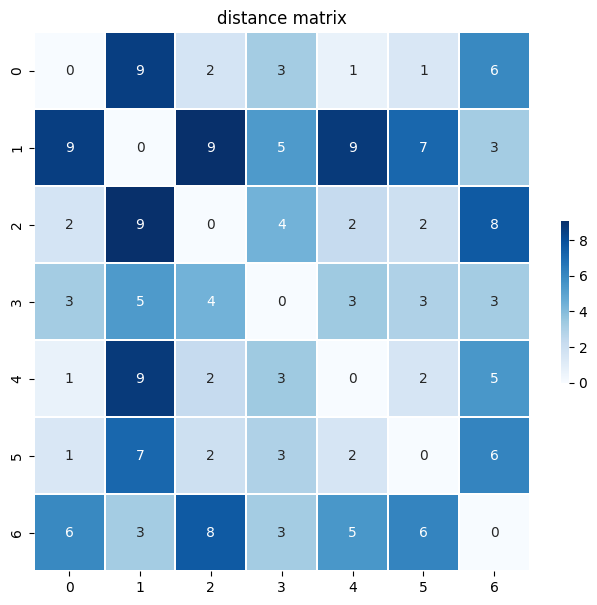

In [265]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(dis1, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

In [266]:
#p = 2, Euclidean Distance

distance_drone = pd.DataFrame(distance_matrix(df[['long', 'lat']].values, df[['long', 'lat']].values, p=2), index=df.index, columns=df.index).values
dis2 = distance_drone
print(dis2)

[[0.         7.44239729 1.1978763  3.00061887 0.48191432 1.00289778
  5.65660813]
 [7.44239729 0.         8.43267199 4.45979189 7.26656079 6.74222518
  2.29501009]
 [1.1978763  8.43267199 0.         4.06716613 1.6327638  1.69491099
  6.76849662]
 [3.00061887 4.45979189 4.06716613 0.         2.80686272 2.44179468
  2.71595338]
 [0.48191432 7.26656079 1.6327638  2.80686272 0.         1.25087672
  5.38823472]
 [1.00289778 6.74222518 1.69491099 2.44179468 1.25087672 0.
  5.15752598]
 [5.65660813 2.29501009 6.76849662 2.71595338 5.38823472 5.15752598
  0.        ]]


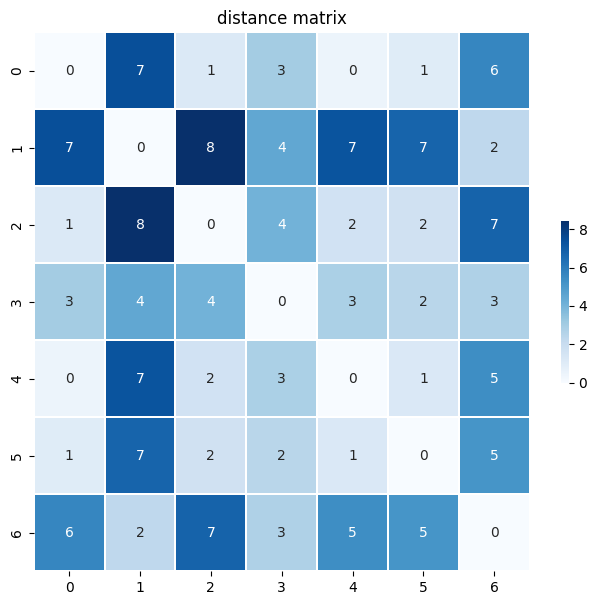

In [267]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(dis2, ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=True, cbar_kws={"shrink": .3}, linewidths=.1)
plt.title('distance matrix')
plt.show()

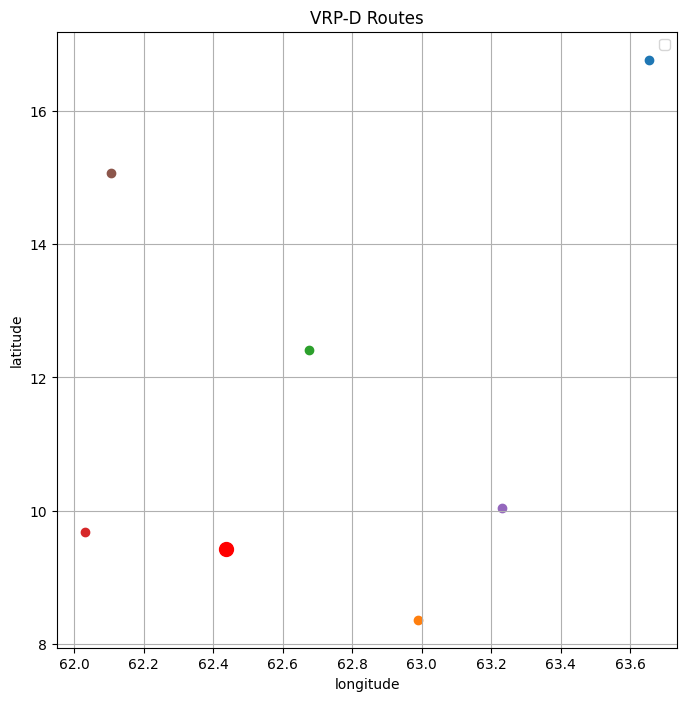

In [268]:
plt.figure(figsize=(8, 8))
# Plotting the routes
for i in range(n_node):
    if i==0:
        plt.scatter(df.long[i], df.lat[i], c='red', label="Depot", s=100)
    else:
        plt.scatter(df.long[i], df.lat[i], label="Customer")
    
plt.legend("Depot", "Customer")

plt.title("VRP-D Routes")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.grid(True)

<a name="toc_40015_3"></a>
## 3. Optimization model


<a name="toc_40015_3.1"></a>

### 3.1 Assumptions

There are many modeling assumptions made in this notebook, as this model serves as a starting point. At the end of the notebook, we suggest potential extensions.
The following are some key assumptions.
- Truck and drone fleets are initially located at the depot. 
- Each drone travels with a distance limit defined by the maximum distance that can be covered with the drone’s battery duration.
- 
- 

<a name="toc_40015_3.2"></a>

### 3.2 Input Parameters


Let us now define the input parameters and notations used for creating the model. The subscript $k$ will be used to denote each truck, $l$ for each drone, and $i$ and $j$ for each nodes.


- $N$: set of all nodes
- $K$: set of all trucks
- $L$: set of all drones

- $d_i$: Demand of node i, where i ∈ N. 
- $truck\_capacity$: Capacity of truck k, where $k \in K $
- $drone\_capacity$: Capacity of drone l, where $l \in L$
- $dis_{i,j,n}$: Distance from node i to node j using distance method n, where i, $j \in N$

The following code loads the Pulp python package and initiates the optimization model. 
 

#### Decision Variables


- $x_{i,j,k}$: if truck k travels from node i to node j, where i, j$ \in N $ and  $k \in K $.
- $y_{i,j,l}$: if drone k travels from node i to node j, where i, j$ \in N $ and  $l \in L $



<a name="toc_40015_3.3"></a>

### 3.3 Full Model
#### Set the Objective: minimize the total cost

Our goal is to **minimize** the total **cost** 

\begin{aligned} 
\textrm{Minimize } \ \sum_{i \in N}\sum_{j \in N}\sum_{k\in K}{dis_{ij1}} * {x_{ijk}} +   \sum_{i \in N}\sum_{j \in N}\sum_{l \in L} {dis_{ij2}} * {y_{ijl}} 
\end{aligned}


#### Constraint #2:
\begin{aligned}
\sum_{j\in{N}\\ j>0}{x_{0jk}} = 1, \quad \forall k \in K 
\end{aligned}

\begin{aligned}
\sum_{i\in{N}\\ i>0}{x_{i0k}} = 1, \quad \forall k \in K 
\end{aligned}

#### Constraint #3:
\begin{aligned}
\sum_{j\in{N}\\ j>0}{y_{0jl}} = 1, \quad \forall k \in K 
\end{aligned}

\begin{aligned}
\sum_{i\in{N}\\ i>0}{y_{i0l}} = 1, \quad \forall k \in K 
\end{aligned}

#### Constraint #4: capacity constraint that trucks and drones can carry
\begin{aligned} 
\sum_{\textrm{i $\in N \{0\}$ }} \ \sum_{ \textrm{ j $\in$ N}\\ i\neq j} d_{i} * x_{i,j,k} &\leq truck\_capacity \quad  \forall \ k \in K, 
\end{aligned}

\begin{aligned} 
\sum_{\textrm{i $\in N \{0\}$ }} \ \sum_{ \textrm{ j $\in$ N}\\ i\neq j} d_{i} * y_{i,j,l} &\leq drone\_capacity \quad  \forall \ l \in D , 
\end{aligned}


#### Constraint #5: network flow constraints 

\begin{aligned} 
\sum_{\textrm{i $\in N $ \\ $i \ne j$ }} \ x_{i,j,k} + \sum_{\textrm{i $\in N $ \\ $i \ne j$ }} \ y_{i,j,k} - \sum_{\textrm{i $\in N $  }} \ x_{i,j,l} - 
\sum_{\textrm{i $\in N $ }} \ y_{i,j,l} = 0 \quad \forall \ j \in N, \forall \ k \in K,  \forall \ l \in L
\end{aligned}



#### Constraint #6 limit the maximum distance a drone can travel.
\begin{aligned} 
\sum_{\textrm{$i \in N$}} \ \sum_{\textrm{$i \in N $} } dis2_{i,j} * y_{i,j,l} &\leq MaxDR \quad  \forall  l \in L \\
\end{aligned}

#### Constraint #7: the removal of subtours for both truck and drone routes

\begin{aligned} 
\sum_{\textrm{$k \in K$}} \ \sum_{\textrm{$(i,j) \in S\\ i\ne j $}}  x_{i,j,k} &\leq |S| - r(s) \quad  \forall  S \subset N\{0\} \\
\end{aligned}

\begin{aligned} 
\sum_{\textrm{$l \in L$}} \ \sum_{\textrm{$(i,j) \in S\\ i\ne j $}}  y_{i,j,l} &\leq |S| - r(s) \quad  \forall  S \subset N\{0\} \\
\end{aligned}


In [269]:
MaxDR = 7

In [270]:
from pulp import * 


In [271]:
%time prob.solve()

for truck in range(1, trucks+1):
    prob =  LpProblem("VRPD", LpMinimize)
    
    xt = pulp.LpVariable.dicts('xt', ((i, j, k) for i in range(n_node) for j in range(n_node) for k in range(trucks)), lowBound=0, upBound=1, cat='Binary' )
    xd = pulp.LpVariable.dicts('xd', ((i, j, kd) for i in range(n_node) for j in range(n_node) for kd in range(drones)), lowBound=0, upBound=1, cat='Binary' )

    #Objective function
    prob +=  pulp.lpSum( pulp.lpSum(dis1[i][j] * xt[i,j,k] if i != j else 0
                          for k in range(trucks) 
                          for j in range(n_node ) 
                          for i in range (n_node ))
                        + pulp.lpSum(dis2[i][j] * xd[i,j,kd] if i != j else 0
                                     for kd in range(drones)
                                     for j in range(n_node )
                                     for i in range(n_node )))
    #constraint 1  each customer node is visited only once by only one vehicle (truck or drone)      
    for j in range(1, n_node ):
        prob += pulp.lpSum(pulp.lpSum(xt[i,j,k] if j != i else 0 
                              for i in range(n_node ) 
                              for k in range(trucks)) + pulp.lpSum(xd[i,j,kd] if j!=i else 0
                                                             for kd in range(drones)
                                                              for i in range(n_node ))) == 1
        
   
    #constraint 2  each truck  depart from the depot and returns to the depot
    for k in range(trucks):
        prob += pulp.lpSum(xt[0,j,k] for j in range(1,n_node )) == 1
        prob += pulp.lpSum(xt[i,0,k] for i in range(1,n_node )) == 1
        
    #constraint 3: each drone departs from the depot and returns to the depot
    for kd in range(drones):
        prob += pulp.lpSum(xd[0,j,kd] for j in range(1,n_node )) == 1
        prob += pulp.lpSum(xd[i,0,kd] for i in range(1,n_node )) == 1
        
    #constraint 4 : capacity constraints
    for k in range(trucks):
        prob += pulp.lpSum(df.demand[j] * xt[i,j,k] if i != j else 0 
                           for i in range(n_node ) for j in range (1,n_node )) <= truck_capacity 

    for kd in range(drones):
        prob += pulp.lpSum(df.demand[j] * xd[i,j,kd] if i != j else 0 
                           for i in range(n_node ) for j in range (1,n_node )) <= drone_capacity 

    ###########
      #constraint 5: flow conservation constraint
    for k in range(trucks):
        for kd in range(drones):
             for j in range (1,n_node):
                    prob += (pulp.lpSum(xt[i,j,k] if i!=j else 0 for i in range(n_node)) 
                             + pulp.lpSum(xd[i,j,kd] for i in range(1,n_node ))
                             - pulp.lpSum(xt[i,j,k] if i!=j else 0 for i in range(n_node))
                             - pulp.lpSum(xd[i,j,kd] for i in range(1,n_node ))) == 0
    
    #Constraint 6: 
    for l in range(drones):
        prob +=pulp.lpSum(2 * dis2[i][j] * xd[i,j,l]  if i != j else 0  for i in range(n_node) for j in range(n_node))<= MaxDR


    #Constraint 7: Subtour elimination constraint
    subtours = []
    for i in range(2,customers):
        subtours+= itertools.combinations(range(1,n_node ), i)
    
    for s in subtours:
        prob += pulp.lpSum(xt[i,j,k] if i !=j else 0 for i,j in itertools.permutations(s,2)
                 for k in range(trucks)) <= len(s) - 1
    
    for s in subtours:
        prob += pulp.lpSum(xd[i,j,kd] if i !=j else 0 for i,j in itertools.permutations(s,2)
                 for kd in range(drones)) <= len(s) - 1
    if prob.solve() == 1:
        print('Vehicle Requirements:', pulp.value(trucks))
        print('Drone Requirements:', pulp.value(drones))
        print('Total cost', pulp.value(prob.objective))
        break       
        

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/souad/.local/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/9333df47fa6c42c9b59f8198ef7e6dc2-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/9333df47fa6c42c9b59f8198ef7e6dc2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 146 COLUMNS
At line 2379 RHS
At line 2521 BOUNDS
At line 2660 ENDATA
Problem MODEL has 141 rows, 138 columns and 1686 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 12.4474 - 0.00 seconds
Cgl0003I 18 fixed, 0 tightened bounds, 21 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 20 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 19 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 15 

In [272]:
soln_dict = {i.name: i.varValue for i in prob.variables()}

for c in prob.constraints.values():
    c_dict = c.toDict()
    # print(c_dict)
    satisfied = False

    LHS = sum([soln_dict[i['name']]*i['value'] for i in c_dict['coefficients']])
    LHS = LHS + c_dict['constant']

    if c_dict['sense'] == 0:
        satisfied = (LHS == 0)

    if c_dict['sense'] == -1:
        satisfied = (LHS <= 0)

    if c_dict['sense'] == 1:
        satisfied = (LHS >= 0)

    print(c)

    if satisfied:
        #print('LHS: ', LHS)
        print('is satisfied')
    else:
        #print('LHS: ', LHS)
        print('not satisfied')

xd_(0,_1,_0) + xd_(0,_1,_1) + xd_(2,_1,_0) + xd_(2,_1,_1) + xd_(3,_1,_0) + xd_(3,_1,_1) + xd_(4,_1,_0) + xd_(4,_1,_1) + xd_(5,_1,_0) + xd_(5,_1,_1) + xd_(6,_1,_0) + xd_(6,_1,_1) + xt_(0,_1,_0) + xt_(2,_1,_0) + xt_(3,_1,_0) + xt_(4,_1,_0) + xt_(5,_1,_0) + xt_(6,_1,_0) = 1
is satisfied
xd_(0,_2,_0) + xd_(0,_2,_1) + xd_(1,_2,_0) + xd_(1,_2,_1) + xd_(3,_2,_0) + xd_(3,_2,_1) + xd_(4,_2,_0) + xd_(4,_2,_1) + xd_(5,_2,_0) + xd_(5,_2,_1) + xd_(6,_2,_0) + xd_(6,_2,_1) + xt_(0,_2,_0) + xt_(1,_2,_0) + xt_(3,_2,_0) + xt_(4,_2,_0) + xt_(5,_2,_0) + xt_(6,_2,_0) = 1
is satisfied
xd_(0,_3,_0) + xd_(0,_3,_1) + xd_(1,_3,_0) + xd_(1,_3,_1) + xd_(2,_3,_0) + xd_(2,_3,_1) + xd_(4,_3,_0) + xd_(4,_3,_1) + xd_(5,_3,_0) + xd_(5,_3,_1) + xd_(6,_3,_0) + xd_(6,_3,_1) + xt_(0,_3,_0) + xt_(1,_3,_0) + xt_(2,_3,_0) + xt_(4,_3,_0) + xt_(5,_3,_0) + xt_(6,_3,_0) = 1
is satisfied
xd_(0,_4,_0) + xd_(0,_4,_1) + xd_(1,_4,_0) + xd_(1,_4,_1) + xd_(2,_4,_0) + xd_(2,_4,_1) + xd_(3,_4,_0) + xd_(3,_4,_1) + xd_(5,_4,_0) + xd_(5,_4,_

In [273]:
for l in range (drones):
    for i in range(n_node):
                for j in range(n_node):
                    if i!=j and pulp.value(xd[i, j,l])== 1:
                        print((i, j,l))

(0, 2, 0)
(4, 0, 0)
(0, 4, 1)
(1, 6, 1)
(4, 0, 1)


In [274]:
for k in range (trucks):
    for i in range(n_node):
                for j in range(n_node):
                    if pulp.value(xt[i, j,k])== 1:
                        print((i, j,k))

(0, 5, 0)
(4, 0, 0)
(5, 3, 0)
(6, 1, 0)


<a name="toc_40015_3.4"></a>
### 3.4 Illustration of Results


[[0, 2, 0], [0, 4, 6, 0], [0, 5, 3, 1, 0]]
#Trucks = 1
#Drones =  2


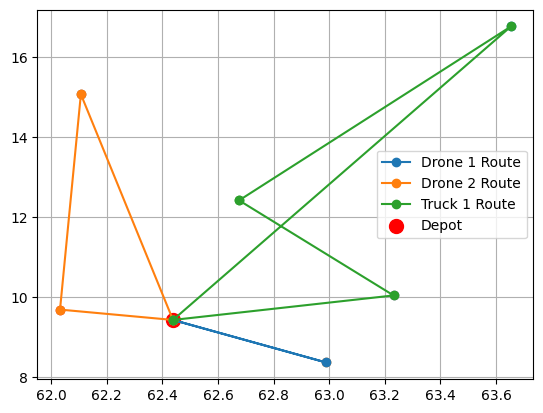

In [284]:
       
# Extract the solution
routes = []

for l in range(drones):
    route1 = [0]  # Start from depot
    for i in range(n_node):
                for j in range( n_node):
                        if  j!=0 and pulp.value(xd[i, j,l])== 1:
                            route1.append(j)
    route1.append(0)  # Return to depot
    routes.append(route1)
    for n in enumerate(route1):
        x_coords = [df.long[node] for node in route1]
        y_coords = [df.lat[node] for node in route1]
    plt.plot(x_coords, y_coords, marker='o', label=f"Drone {l+1} Route")

for k in range(trucks):
    route = [0]  # Start from depot
    for i in range(n_node):
            for j in range(n_node):
                if j!=0 and pulp.value(xt[i, j, k])== 1:
                    route.append(j)
    route.append(0)
    routes.append(route)
    for n in enumerate(route):
        x_coords = [df.long[node] for node in route]
        y_coords = [df.lat[node] for node in route]
    plt.plot(x_coords, y_coords, marker='o',  label=f"Truck {k+1} Route")

print(routes)
print('#Trucks =',  trucks)
print('#Drones = ',drones)
print('#Drones = ',MaxDR)


for i in range(n_node):
    if i == 0:
        # Plot the depot
        plt.scatter(df.long[i], df.lat[i], c='red', label="Depot", s=100)
    else:
        # Plot the customers
        plt.scatter(df.long[i], df.lat[i])
        

        

plt.grid(True)
plt.legend()

plt.show()


<a name="toc_40015_4"></a>
## 4 Computaional Experiments


## 5 Cilents senarios
### Table 1: Cost results
| Senario Code | Z(Total cost)|Running Time|#Trucks |#Drones|
| --- | --- | --- |---|---|
| C5T1D2 | 14.51453062 | 0.01s |1|2|
| C6T2D3|  n | . |5|6|
| C7T2D2 |  20.18994490 | 0.07s |5|8|
| C8T10D11 |  n | . |5|10|
| C9T4D3 |  n | . |5|12|

## 10 Cilents senarios
### Table 1: Cost results
| Senario Code | Z(Total cost)|Running Time| #Trucks |#Drones|
| --- | --- | --- |---|---|
| C10P5T4D5 | 144320 | 6min 35s |5|4|
| C5P5T6D7|  n | . |5|6|
| C5P5T8D9 |  n | . |5|9|
| C5P5T10D11 |  n | . |10|11|
| C5P5T12D13 |  n | . |12|13|